MATH60629A
=======

Tutorial: An Introduction to Practical Machine Learning
=============


This tutorial provides a short introduction to the practice of machine learning.

We assume that the user already has an understanding of the basic concepts that underlie the field. We review both methodological concepts like supervised learning and also use software libraries such as `scikit-learn`, `pandas`, and `numpy`.

In particular, we will:
1. load some data,
2. fit different supervised models on variations of the data,
3. and compare results.

This tutorial is not meant to be exhaustive (references are provided throughout, and links to extra material are provided at the end).  

### Authors:
- Laurent Charlin <lcharlin@gmail.com>

### Table of Content

- [Section 0. Introduction](#introduction)
- [Section 1. Data Pre-Processing](#pre-processing)
- [Section 2. Modelling](#modelling)
- [Section 3. Concluding Remarks](#concluding-remarks)

<a id='introduction'></a>
### Section 0. Introduction
We will use the example of a recommender system, i.e., a system which must recommend movies of interests to its users (e.g., Netflix). We will model user-movie preferences from a popular publicly available dataset (Movielens 1M). We will learn, from past user-movie ratings, to predict (missing/future) user-movie ratings from user socio-demographics and movie-tags data.

Mathematically, we are interested in learning the (parameters of the) following function:

$$ r_{um} = f_\theta(x_u, x_m)$$
where
- $u$ indexes users
- $m$ indexes items
- $r_{um}$ is u's rating for m (that user's preference) -- the dependent variable
- $f_\theta$ is some model parametrized by $\theta$. For example, a linear regression with coefficients $\theta$
- $x_u$ are user u's covariates (e.g., age and occupation of this user)
- $x_m$ are movie m's covariates (e.g., tags associated with the movie)

The function $f$ can take several forms (in other words, we can use a variety of models for this task). In today's tutorial we will assume that the problem is a regression one and we will experiment with several models ranging from a simple linear regression model to a more complicated two-hidden layer neural network.


### Machine Learning terminology

It can be useful to think of machine learning as comprising three elements:
1. Task (T)
2. Experience (E)
3. Performance measure (P).

(a good description of these concepts is provided in [Ch. 5 of the Deep Learning Book](https://www.deeplearningbook.org/contents/ml.html))

The intuition is that the task (T) is "the type of problem you are trying the solve" (e.g., classification, regression, anomaly detection), the experience (E) is "how your data comes about" (e.g., does it come with labels or not, do you observe it all at once or as a stream), and the performance (P) is "how well your model does". Standard performance measures include accuracy and mean-squared error.  

Note that the above terminology does not define the model used to learn (fit) the data nor does it define the fitting procedure (e.g., gradient descent).

Relationship to the problem of rating prediction:
- Task: Our task is to predict user-movie ratings. It can be modelled in different ways (more on this during week 11), but here we will model it as a regression problem.
- Experience: The experience is a supervised learning one because we are predicting some dependent variable (rating) from a set of independent variables
- Performance measure: We will be using the mean-squared error (MSE).

### Setting up the data

For supervised learning, it is customary, to construct two data matrix $X$ and $Y$. The former, $X$, contains the covariates (features). It is a matrix of size $n \times p$ with $n$ the number of examples and $p$ the dimensionality of each example (in other words the number of covariates associated with each example).  They are the input to the function.

$$X = \begin{bmatrix}
x_{11} & x_{12} & \ldots & x_{1p} \\
\vdots & \vdots       &  \ddots      & \vdots \\
x_{n1} & x_{12} & \ldots & x_{np} \\
\end{bmatrix}
$$

The latter, $Y$, is a (column) vector of length $n$ which contains the labels (here ratings). $Y_1$ corresponds to the rating of $X_1$ (row  contains the labels (here ratings).

$$
Y = \begin{bmatrix}
r_1 \\
r_2 \\
\vdots \\
r_n
\end{bmatrix}$$

Of course, in a real problem we will differentiate the `train` and `test` sets, e.g., with $X_\text{train}$ and $X_\text{test}$. Same for the labels using, e.g., $Y_\text{train}$ and $Y_\text{test}$.

## Start

Following this brief introduction, we now dive into the problem.

In [31]:
# We first download the repo to get access to data and some utility code (This is specifically for colab.)
!rm -rf 80-629/
!git clone https://github.com/lcharlin/80-629/

Cloning into '80-629'...
remote: Enumerating objects: 977, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 977 (delta 0), reused 1 (delta 0), pack-reused 973 (from 2)
Receiving objects: 100% (977/977), 113.11 MiB | 25.55 MiB/s, done.
Resolving deltas: 100% (566/566), done.
Updating files: 100% (104/104), done.


We begin by importing the packages that we will need:
- `reduce` function will come in handy to iteratively process data
- `os` standard packages for performing system operations (e.g., opening files)
- `re` package for regex
- `sys` package to deal with system-level operations (here used to change the search path)
- `time` package we will use to measure the duration of certain operations



- `matplotlib` for plotting
- `numpy` for linear-algebra computations
- `pandas` for data wrangling
- `sklearn` (scikit-learn) for machine learning models and useful machine learning related routines

In [32]:
from functools import reduce
import os
import re
import time

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import neural_network

import sys
sys.path += ['80-629/week4-PracticalSession/']
from local_utils import DrawNN

<a id='pre-processing'></a>
# Section 1: Data Pre-Processing

In the following we load data from several csv files and pre-process it.

While this is not really machine learning, machine learning needs data and so knowing how to manipulate (and how to plot) data in python is quite useful. (In fact, in lots of use cases, data acquisition and cleaning will often take more of your time than running the machine learning models.)

**I suggest that you read this section, but that you spend most of your time on the other sections. If you have time at the end, you can come back and do this more thoroughly.**

#### Details

We will use the publically available [movielens dataset](https://grouplens.org/datasets/movielens/). The group behind movielens has released several useful datasets in the last 20 years. Here we will focus on the [ML-1M data](https://grouplens.org/datasets/movielens/1m/) (it contains 1M ratings) but we will also use movie tags from the [ML-20M dataset](https://grouplens.org/datasets/movielens/20m/) (20M ratings).

Except for downloading the dataset (to save you some time), I have not processed nor modified the data in any way.

In [33]:
ROOT_DIR='80-629/week4-PracticalSession'
DATA_DIR=os.path.join(ROOT_DIR, 'dat/ml-1m/') # this is where most of our data lives
DATA_DIR_20ML=os.path.join(ROOT_DIR, 'dat/ml-20m/') # for the tags data

#### Load Movie Names/Genres

We begin by loading the data that describes movies in the ML-1M dataset. Each line in the file contains one entry in the following format `MovieID::Name::Genres`.

After loading into a pandas `dataFrame` structure, we will have movie names (`mName`), IDs (`mid`), and movie genres (`mGenres`)

In [34]:
movies_pd = pd.read_csv(os.path.join(DATA_DIR, 'movies.dat'),
                        sep='::',
                        names=['mid', 'mName', 'mGenres'], engine='python',
                        encoding='latin-1')

In [35]:
print(f'The dataset contains {movies_pd.shape[0]} movies')

The dataset contains 3883 movies


In [36]:
display(movies_pd.head())

,mid,mName,mGenres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Using pandas we can also search for movies by `mid` or by their name:

---



In [37]:
mid = 10
display(movies_pd[movies_pd.mid==mid])

name = 'Machine'
display(movies_pd[movies_pd.mName.str.contains(name,
                                               regex=False, case=False)])

,mid,mName,mGenres
9,10,GoldenEye (1995),Action|Adventure|Thriller


,mid,mName,mGenres
1409,1433,"Machine, The (1994)",Comedy|Horror


#### Load Ratings

Using a similar routine as above, we load the ratings data which is in this format `UserID::MovieID::Rating::Timestamp`, and we will name the column UserID with `uid`, the column MovieID with `mid`, the rating with `rating`, and the time of the rating with `timestamp`.

In [38]:
ratings_pd = pd.read_csv(os.path.join(DATA_DIR, 'ratings.dat'),
                         sep='::',
                         names=['uid', 'mid', 'rating', 'timestamp'],
                         parse_dates=['timestamp'],
                         infer_datetime_format=True,
                         engine='python')

display(ratings_pd.head())

/tmp/ipython-input-2439902251.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ratings_pd = pd.read_csv(os.path.join(DATA_DIR, 'ratings.dat'),
/tmp/ipython-input-2439902251.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ratings_pd = pd.read_csv(os.path.join(DATA_DIR, 'ratings.dat'),


,uid,mid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [39]:
print(f"""The dataset contains {ratings_pd.shape[0]} ratings,
      from {ratings_pd.uid.nunique()} users,
      and {ratings_pd.mid.nunique()} items.""")

The dataset contains 1000209 ratings, 
      from 6040 users, 
      and 3706 items.


#### Load User Socio-Demographics Information

The file is in this format `UserID::Gender::Age::Occupation::Zip-code`, which we will load in a `dataFrame` with the following column names `uid,gender,age,occupation,zip`.



In [40]:
users_pd = pd.read_csv(os.path.join(DATA_DIR, 'users.dat'),
                       sep='::',
                       names=['uid', 'gender', 'age', 'occupation', 'zip'],
                       engine="python")

display(users_pd.head())

,uid,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [41]:
print(f'This table contains {users_pd.shape[0]} users')

This table contains 6040 users


Further we will truncate the 5-digit zip codes and only keep the leading two digits. The reason is that we will treat this variable as a categorical one and with only ~6K users and >3.4K unique zip codes, it is unlikely that we can learn precise enough coefficients for this feature.

In [42]:
print(f'We originally have {users_pd.zip.nunique()} different zip codes')
users_pd['zip'] = users_pd['zip'].apply(lambda x: x[:2])
display(users_pd['zip'].head())
print(f'By only keep the first two digits of each zip code, \
we reduced the unique number of zip codes to {users_pd.zip.nunique()}.')

We originally have 3439 different zip codes


,zip
0,48
1,70
2,55
3,02
4,55


By only keep the first two digits of each zip code, we reduced the unique number of zip codes to 100.


#### Load Movie Tags

The remaining data to be loaded are the movie tags (we will actually use the tags from the ml-20M dataset). The tags are user generated. Further each movie-tag pair comes with an affinity score (intuitively, if numerous users have used a tag on a particular movie than the tag-movie pair will have a high affinity).

We will load the csv data `movieId,tagId,relevance` into a `dataFrame` with the columns `mid,tid,relevance`.

In [43]:
# load ml-20m tags
tags_scores = pd.read_csv(os.path.join(DATA_DIR_20ML, 'genome-scores.csv.gz'),
                          skiprows=1,
                          names=['mid', 'tid', 'relevance'])
display(tags_scores.head(10))

,mid,tid,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675
5,1,6,0.21700
6,1,7,0.06700
7,1,8,0.26275
8,1,9,0.26200
9,1,10,0.03200


In [44]:
print(f'The data contains {tags_scores.tid.nunique()} unique tags.')
print(f'Affinities (relevances) are contained in the {tags_scores.relevance.min()}--{tags_scores.relevance.max()} range.')
display(tags_scores.relevance.describe())

The data contains 1128 unique tags.
Affinities (relevances) are contained in the 0.0002499999999999--1.0 range.


,relevance
count,1.170977e+07
mean,1.164833e-01
std,1.542463e-01
min,2.500000e-04
25%,2.425000e-02
50%,5.650000e-02
75%,1.415000e-01
max,1.000000e+00


From above we see that affinities (relevance) basically span the 0 to 1 range, and have an average of 0.12.

We also load the tag names. This will be useful for exploration purposes.

In [45]:
tags_names = pd.read_csv(os.path.join(DATA_DIR_20ML, 'genome-tags.csv'), skiprows=1, names=['tid', 'tName'])
display(tags_names.head(10))

,tid,tName
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
5,6,1950s
6,7,1960s
7,8,1970s
8,9,1980s
9,10,19th century


Since we loaded tag scores from a different dataset (ml-20M), we only need the tags that correspond to movies  in the original data (ml-1M). Luckily, since both datasets are from movielens, the movie ids (`mid`) are the same across these two datasets (i.e., not need for messy string match).

(Note: Pandas' functionalities allow you to do operations similar to what you would do in SQL for relational databases.)

In [46]:
tags_scores = tags_scores.loc[tags_scores['mid'].isin(ratings_pd['mid'].unique())]
print(tags_scores.mid.nunique())

3470


We lost a few movies compared to the original count of 3706 but we can live with that.

Next, instead of using the tag scores, we only keep the highly relevant tags for each movie. In other words, we assume that the presence of a tag is more meaningful than its absence. This also has the side benefit of reducing the number of available tags per movie.

In [47]:
# Keep only high-relevance tags (here this is defined as having a relevance above 0.9)
print('unique tags:', tags_scores['tid'].nunique())
tags_scores_high = tags_scores.loc[tags_scores['relevance'] > 0.9]
print('unique tags w. high relevance:', tags_scores_high['tid'].nunique())

unique tags: 1128
unique tags w. high relevance: 968


#### Explore tags

Let's get some understanding of how these tags are used. To help, we first build a `dataFrame` that contains, the tag names, the movie name, and its relevance (recall that currently these are in three different tables, as the tag relevance contains tag and movie IDs but not their names).

Pandas' `merge` function can be used to join two dataFrames that share a common key. (This is an operation inspired by inner joins in SQL.)

In [48]:
tags_high_names_movies = pd.merge(tags_scores_high, tags_names, how='inner', on='tid')
tags_high_names_movies = pd.merge(tags_high_names_movies, movies_pd, how='inner', on='mid')
display(tags_high_names_movies.head())

,mid,tid,relevance,tName,mName,mGenres
0,1,63,0.93325,animated,Toy Story (1995),Animation|Children's|Comedy
1,1,64,0.98575,animation,Toy Story (1995),Animation|Children's|Comedy
2,1,186,0.95650,cartoon,Toy Story (1995),Animation|Children's|Comedy
3,1,203,0.92625,childhood,Toy Story (1995),Animation|Children's|Comedy
4,1,204,0.96425,children,Toy Story (1995),Animation|Children's|Comedy


Similarly as above we can search for top movies according to a particular tag:

In [49]:
tag = 'scary' # This is the (sub) tag we search for
display(tags_high_names_movies[
    tags_high_names_movies.tName.str.contains(tag,
                                               regex=False, case=False)].sort_values(by=['relevance'],
                                                                                    ascending=False))

,mid,tid,relevance,tName,mName,mGenres
11087,2710,882,0.96700,scary,"Blair Witch Project, The (1999)",Horror
5671,1342,882,0.96625,scary,Candyman (1992),Horror
5698,1347,882,0.96550,scary,"Nightmare on Elm Street, A (1984)",Horror
15530,3892,882,0.96475,scary,Anatomy (Anatomie) (2000),Horror
8025,1997,882,0.96200,scary,"Exorcist, The (1973)",Horror
10380,2550,882,0.95625,scary,"Haunting, The (1963)",Horror|Thriller
5714,1350,882,0.94675,scary,"Omen, The (1976)",Horror
11542,2841,882,0.94650,scary,Stir of Echoes (1999),Thriller
7872,1974,882,0.94625,scary,Friday the 13th (1980),Horror
5891,1387,882,0.94250,scary,Jaws (1975),Action|Horror


This next step will allow us to further explore the tags data while providing an additional step of pre-processing that will be helpful for fitting this data.

In the current dataset, every movie-tag id pair is a separate entry (row of the `dataFrame`). Thinking ahead, we will want to use all tags as covariates to predict a single rating. As such, we want to construct a data matrix where each line corresponds to a single example.

To do so, we re-encode `tid`s using a 1-of-K encoding (also known as using dummy variables). This is important to encode categorial variables (e.g., "cats" and "dogs") which may be represented numerically but but which cannit be ordered. For example, here each tag has a numerical index (e.g., tag `scary` is id `882`) but tags cannot be compared using their numbers (e.g., tag `882` is not "bigger" than tag `880` or smaller than tag `900`). 1-of-K encoding deals with this by encoding each tag as a binary vector of length $K$ with a single non-zero value which corresponds to the tag. In the present case, $K=968$ tags, and tag `scary` would have a `1` at position `882`.

Below we see that our data now has 971 columns: 968 for tag ids, 1 for `mid`, and 1 for `relevance`, and 1 for the pandas index.

In [50]:
#print(tags_scores_high.shape)
tags_scores_high_dum = pd.get_dummies(tags_scores_high, columns=['tid'])
tags_scores_high_dum = tags_scores_high_dum.reset_index()
#print(tags_scores_high_dum.shape)
display(tags_scores_high_dum.head())
tags_per_movie = tags_scores_high_dum.groupby("mid").sum()

,index,mid,relevance,tid_1,tid_2,tid_3,tid_5,tid_6,tid_7,tid_9,...,tid_1119,tid_1120,tid_1121,tid_1122,tid_1123,tid_1124,tid_1125,tid_1126,tid_1127,tid_1128
0,62,1,0.93325,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,63,1,0.98575,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,185,1,0.95650,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,202,1,0.92625,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,203,1,0.96425,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


With this data we can then explore the distribution of movies per tag (and tags per movie below).

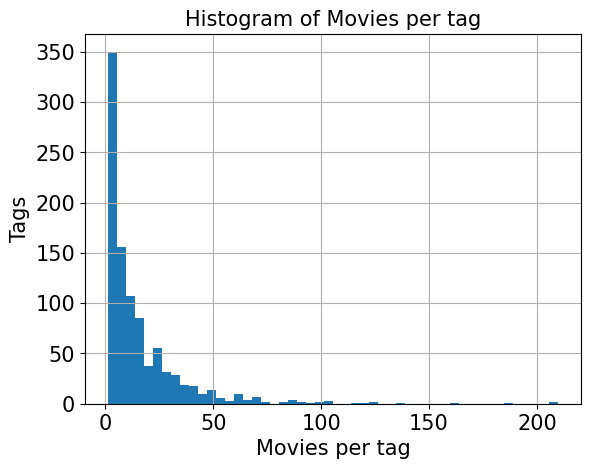

In [51]:
th = tags_scores_high.groupby("tid").count()
hists = th.hist(bins=50, column="mid", xlabelsize=15, ylabelsize=15)[0][0]
hists.set_ylabel("Tags", size=15)
hists.set_xlabel("Movies per tag", size=15)
hists.set_title("Histogram of Movies per tag", size=15);

In this histogram each bar corresponds to the number of tags (y-axis) associated with a particular number of movies. For example, there are 350 tags that were used to tag a small number of movies (<5). On the other hand, the most popular tag was used to tag 210 movies.

We note that the distribution is heavily skewed to the left which indicates that most tags are only used on a small number of movies.

In [52]:
tname = tags_names.at[tags_names.tid.eq(th.mid.idxmax()).idxmax(), 'tName']
print(f'The most popular tag "{tname}" has been used for {th.mid.max()} movies')

The most popular tag "comedy" has been used for 210 movies


Using the same recipe, we can do something similar for movies instead of tags

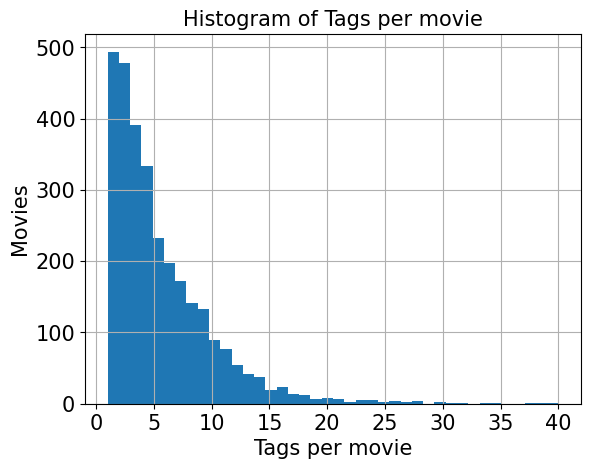

In [53]:
hists = tags_scores_high.groupby("mid").count().hist(bins=40, column="tid", xlabelsize=15, ylabelsize=15)
hists[0][0].set_ylabel("Movies", size=15)
hists[0][0].set_xlabel("Tags per movie", size=15)
hists[0][0].set_title("Histogram of Tags per movie", size=15);

In this histogram each bar corresponds to the number of movies (y-axis) associated with a particular number of tags. For example, there are a bit less than 500 movies that received exactly 1 tags. On the other hand, the most popular movie received almost 40 tags.

#### Question 1
What is the most popular movie in terms of tag (the one with almost 40 tags)? Bonus: Can you list the top 5 movies in terms of number of tags?

Note: this question tests you understanding of the pandas library. You can safely skip it and, in any case, don't spend more than five minutes on it.

In [54]:
mh = tags_scores_high.groupby("mid").count()
mname = movies_pd.loc[movies_pd['mid'] == mh.tid.idxmax()].mName.to_string()
print(f'The most popular movie "{mname}" has {mh.tid.max()} tags')

The most popular movie "2502    Matrix, The (1999)" has 40 tags


In the next few steps we further pre-process our data in order to create a dataset for supervised learning. Recall, that we wish to predict user-movie preferences from user and movie features.

For the purpose of this tutorial, we will only use a small fraction of our dataset to ensure that all operations (and especially model fitting) can be done in a matter of minutes.

In [55]:
# Join users, ratings, and tags
data_pd = pd.merge(users_pd, ratings_pd, how='inner', on='uid')

# shuffle data and keep 2% of the ratings.
# (this small percentage ensures that all computations in this tutorial are fast)
data_pd = data_pd.sample(frac=0.02, random_state=1234)

data_pd = pd.merge(data_pd, tags_per_movie, how='inner', on='mid')

print(data_pd.shape)

(19224, 978)


We can have a look at our current dataset.

In [56]:
print('Final descriptive stats of our dataset.')
print('\t- %d items'   % data_pd['mid'].nunique())
print('\t- %d users'   % data_pd['uid'].nunique())
print('\t- %d ratings' % data_pd.shape[0])

Final descriptive stats of our dataset.
	- 2396 items
	- 4628 users
	- 19224 ratings


Notice that we have several categorical variables (e.g., gender, occupation, zip, mid). Below, we transform these using dummy variables (just like we did above for tags).

In [57]:
print(data_pd.shape)
display(data_pd[:10])

(19224, 978)


,uid,gender,age,occupation,zip,mid,rating,timestamp,index,relevance,...,tid_1119,tid_1120,tid_1121,tid_1122,tid_1123,tid_1124,tid_1125,tid_1126,tid_1127,tid_1128
0,2887,M,25,3,66,434,4,972143077,1846259,3.86425,...,0,0,0,0,0,0,0,0,0,0
1,2776,M,25,14,22,529,5,973055600,2275114,3.76550,...,0,0,0,0,0,0,0,0,0,0
2,1880,M,35,0,91,2088,2,975378713,4115151,1.90400,...,0,0,0,0,0,0,0,0,0,0
3,2472,M,25,18,37,1200,4,974235584,31192746,24.52100,...,0,0,0,0,0,0,0,0,0,0
4,2407,M,35,16,11,858,5,974254899,19885099,22.06975,...,0,0,0,0,0,0,0,0,0,0
5,1523,M,25,17,95,1220,5,974745762,10988979,8.55275,...,0,0,0,0,0,0,0,0,0,0
6,3389,M,18,0,13,2288,3,967515184,27119064,11.38350,...,0,0,0,0,0,0,0,0,0,0
7,3184,F,25,18,21,1094,5,968767262,1108744,0.90550,...,0,0,0,0,0,0,0,0,0,0
8,2056,M,25,4,56,2640,4,974816383,34114830,12.54975,...,0,0,0,0,0,0,0,0,0,0
9,4088,M,25,3,77,216,2,965432491,2295355,9.59925,...,0,0,0,0,0,0,0,0,0,0


In [58]:
cols = ['gender','occupation','zip','mid','uid']
data_pd_dum = pd.get_dummies(data_pd, columns=cols)
print(data_pd_dum.shape)
display(data_pd_dum.head(10))

(19224, 8119)


,age,rating,timestamp,index,relevance,tid_1,tid_2,tid_3,tid_5,tid_6,...,uid_6027,uid_6030,uid_6032,uid_6033,uid_6034,uid_6035,uid_6036,uid_6037,uid_6039,uid_6040
0,25,4,972143077,1846259,3.86425,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,25,5,973055600,2275114,3.76550,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,35,2,975378713,4115151,1.90400,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,25,4,974235584,31192746,24.52100,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,35,5,974254899,19885099,22.06975,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
5,25,5,974745762,10988979,8.55275,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
6,18,3,967515184,27119064,11.38350,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
7,25,5,968767262,1108744,0.90550,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
8,25,4,974816383,34114830,12.54975,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
9,25,2,965432491,2295355,9.59925,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


While we used pandas to create dummies, `scikit-learn` has similar capacities. The `preprocessing` module is detailed [here](https://scikit-learn.org/stable/modules/preprocessing.html). You can also checkout the section on [Categorical features](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features).


We are ready to construct our first dataset. We will first use a subset of the columns (not including tags).

Below you will also note that we split our data into train and test using `train_test_split` from scikit-learn.

In [59]:
attributes = "mid_*|uid_*|gender_*|age|zip_*|occupation_*"
X = data_pd_dum.filter(regex=('('+attributes+')'))
print(X.shape)

rating = data_pd_dum['rating']
print(rating.shape)

# Split Train/Test
# Keep 40% of the data for testing.
# 40% is a bit high in practice, using 10%--20% is more usual.
X_train, X_test, y_train, y_test = train_test_split(
    X, rating, test_size=0.4, random_state=1234, shuffle=False)

(19224, 7147)
(19224,)


*Recommender Systems note:* We split the dataset without looking at users and items. In other words, more active users and popular items will be (on average) more represented in the heldout data. If this is not desired, for example one may wish a fairer treatment of users. We could then ensure that each user has the same amount of data in the heldout set (and similarly for items).

*Recommender Systems note #2:* Practically speaking it would make more sense to divide ratings by timestamp. That is, train on ratings up to some date and test on ratings after that date (future ratings).

In [60]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11534, 7147) (7690, 7147) (11534,) (7690,)


<a id="modelling"></a>
# Section 2: Modelling

Ratings ([likert scale](https://en.wikipedia.org/wiki/Likert_scale)) are ordinal quantities. However, for ease of modelling and evaluation we treat ratings as real-valued (we will discuss in greater length some of these issues later this semester). Concretely, we will measure the loss/error using a mean-squared error function:

$$ \text{MSE}(f(x),y) := \frac{1}{n} \sum_{i=0}^n (f(x_i) - y_i)^2$$

The MSE can be understood as the average square distance between the predictor $f(x_i)$ and the target $y_i$. MSE returns a non-negative quantity and the perfect predictor has an MSE of $0$. If Model 1 has a smaller MSE than Model 2, its performance is higher according to that metric.

*Train/Test:* Recall that while we estimate the parameters of the model using the **train** data, we evaluate the quality of the model (its performance) using **test** data.

### 2.1 A first model: mean predictor

It is often helpful to use a very simple benchmark to compare against the performance of our models.

Our initial benchmark is a model which simply predicts the mean (train) rating.

*Recommender Systems note:* We could obtain a slightly better model by predicting with a user- or item-specific mean instead of the global mean.

In [61]:
# Check accuracy of constant predictor

print("Constant predictor")

print("\tTrain mean-squared error: %.3f"
      % mean_squared_error(y_train,
                           np.full_like(y_train, y_train.mean())))
print("\tTest mean-squared error: %.3f"
      % mean_squared_error(y_test,
                           np.full_like(y_test, y_train.mean())))

Constant predictor
	Train mean-squared error: 1.587
	Test mean-squared error: 1.610


The train and test errors are just about the same (I imagine that difference is not statistically significant). Our model is very simple (in machine learning term it has a high bias) and so you would not expect its performance to fluctuate much on the test set (i.e., small variance).

In terms of absolute values these indicate that, on average, our predictions are 1.3 units ($\sqrt{1.6}$) away from the true rating. This indicates that you shouldn't be too surprised that the model gives a rating below 4 to a movie that you would rate as a 5. Having said that, it is difficult to know how good this is before we compare to other methods.

### 2.2 Linear regression

For our second model, we will fit a linear regression that uses user features to predict ratings. In particular we use the users' gender, age, zip, and occupation. We fit this model
$$
f(x_{ui}) = \theta_\text{gender} x_{\text{gender}_u} + \theta_{\text{age}} x_{\text{age}_u} + \theta_\text{zip} x_{\text{zip}_u} + \theta_\text{occupation} x_{\text{occupation}_u} + \theta_\text{uid} x_{\text{uid}_u} + \theta_{\text{mid}} x_{\text{mid}_i}
$$

**𝑥
x = the feature (0 or 1 for gender).

𝜃
θ = the weight, a number the model learns**

$\theta_{1:6}$ are the parameters, $\text{gender}_u$ stands for the gender of user $u$ and similarly for other covariates. Also, $x_{\text{uid}_u}$ represents the identity of the user and similarly for $x_{\text{mid}_i}$ and movies.

Note that some of these variables are categorial so in fact they are associated with a vector of parameters. For example, zip is a categorical variable with 100 different possible values and so $\theta_{\text{zip}}$ has 100 dimensions.

Training this model involves minimizing the train MSE, this is exactly what the `LinearRegression` class does. (This is a [least-squares problem](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html) and it can be solved in closed form.)

In [62]:
# Create linear regression object
reg = linear_model.LinearRegression()

# Train the model using the training sets
reg.fit(X_train, y_train)

print("Number of parameters: ", reg.coef_.shape[0]+1)

Number of parameters:  7148


In [63]:
# Make train predictions
y_train_pred = reg.predict(X_train)

print("Train Mean squared error: %.3f"
      % mean_squared_error(y_train, y_train_pred))

# Make test predictions
y_test_pred = reg.predict(X_test)

print("Test Mean squared error: %.3f"
      % mean_squared_error(y_test, y_test_pred))

Train Mean squared error: 0.385
Test Mean squared error: 1.462


We note that train error $<<$ test error ($<<$ stands for "much smaller"). This is a clear case of overfitting. That is, the model has learned the training data and cannot generalize to new unseen data (it's a low bias and high variance model).

Different methods can help prevent the model from overfitting, this is often referred to as *regularizing* the model. Here we will add a penalty that constrains the learned parameters to stay close to zero. Intuitively, this learns a function that is smoother and, the hope is, that generalizes better. This penalty or regularizer is added to the loss function which becomes: $$  \text{loss} := \text{MSE} + \alpha \sum_i ||\theta_i||_2^2 $$

Instead of the previous $ \text{loss} := \text{MSE} $.

Note:
- $||\cdot||_2$ stands for the 2-Norm. That is, the square root of the sum of the operand's squared elements.
- $\alpha$ is a hyper-parameter which denotes the strength of the regularizer (if $\alpha=0$ the regularizer vanishes and if $\alpha=\infty$ all parameters must be equal to exactly 0). A hyperparameter is a parameter that is not learned during training but set a priori (here, learning $\alpha$ along with the $\theta$s would lead to a $\alpha=0$).

During learning the model must then tradeoff performance (MSE) and complexity (high $\theta$s). There are different names for this particular regularizer including weight decay, L2-regularization, and ridge (regression). Scikit-learn offers the `Ridge` class from the `linear_model` package to fit regularized linear regression models.

In [64]:
# Create linear regression object
regr = linear_model.Ridge(alpha=10)

# Train the model using the training sets
start = time.time()
regr.fit(X_train, y_train)
fit_time = time.time() - start

print("Fitting time: %.2f seconds" % fit_time)

print("Number of parameters:", regr.coef_.shape[0]+1)

Fitting time: 25.38 seconds
Number of parameters: 7148


**Question 3** Explain why there are 7,184 parameters.

**Hint:** Don't forget the intercept/bias term

In [65]:
# Make train predictions
y_train_pred = regr.predict(X_train)

print("Train Mean squared error: %.3f"
      % mean_squared_error(y_train, y_train_pred))

# Make test predictions
y_test_pred = regr.predict(X_test)

print("Test Mean squared error: %.3f"
      % mean_squared_error(y_test, y_test_pred))

Train Mean squared error: 0.791
Test Mean squared error: 1.077


Compared to above, we see that with $\alpha=10$ the train and test errors are much closer (i.e., there's less overfitting). Presumably different values of $\alpha$ would yield different generalizations.


**Question 4** How do you find the "best" value of $\alpha$ for a given model and dataset?

**Hint:** Have a look at the [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV), a cross-validation enabled version of Ridge. (you can use two-fold cross validation, i.e. cv=2)

**Answer:** See below.

In [66]:
# Create linear regression object
regRCV = linear_model.RidgeCV(alphas=[1, 10, 100], cv=2)

# Train the model using the training sets
regRCV.fit(X_train, y_train)

print("Number of parameters: %d, estimated alpha: %d" % (regRCV.coef_.shape[0], regRCV.alpha_))

Number of parameters: 7147, estimated alpha: 10


Pick candidate α values
Example:
[
1
,
10
,
100
]
[1,10,100].

For each α:

Split the training data into
𝐾
K folds (say 5).

For each fold:

Train the model with that α on
𝐾
−
1
K−1 folds.

Evaluate MSE on the held-out fold.

Average the MSE across all folds → gives you the CV score for that α.

Compare across α values

α = 1 → avg MSE = 1.15

α = 10 → avg MSE = 1.05

α = 100 → avg MSE = 1.20
👉 Best α = 10 (lowest average MSE).

Final step:

Retrain Ridge with α = 10 on the entire training set.

Then evaluate once on the test set for the final unbiased error.

Technical remark: since the optimization is often done in log space, it's typical for the set of $\alpha$'s to be powers of 10.

In [ ]:
# Make train predictions
y_train_pred = reg.predict(X_traib)

print("Train Mean squared error: %.3f"
      % mean_squared_error(y_train, y_train_pred))

# Make test predictions
y_test_pred = ...

print("Test Mean squared error: %.3f"
      % mean_squared_error(y_test, y_test_pred))

The advantage of doing cross validation (for example using `RidgeCV`) is clear. It automatically searches for the best values of hyperparameters (here $\alpha$) from a given set (here $\{ 1, 10, 100 \}$).

A validation set (or cross validation) should always be used to search for good hyperparameters (especially for non-linear models different values of hyperparameters may give very different results). In certain cases you may have to manually implement validation. In such cases you will likely need to split a separate validation set from your training data--in `sklearn` you can use the `train_test_split` function. It is typical for the validation set to be the same size as the test set.

You should also remember to **never select model hyperparameters based on performance on test set**, this would give you over-optimistic results because you are effectively using your test set to tune your models (its hyperparameters). The main purpose of the test set is to provide an unbiased way of comparing different models.

***

Armed with a good model we can explore the learned model including some of its predictions

In [67]:
# helper function to return non-zero columns
def non_zero(row, columns):
    col_name = list(columns[~(row == 0)])[0]
    #r = re.sub('mid_','',l)
    return col_name

In [68]:
# get number of ratings per movie (popularity)
mids = X_test.filter(regex=('mid_*'))
y_mid_cols = mids.apply(lambda x: non_zero(x, mids.columns), axis=1)
movie_popularity = X_train.filter(regex=('mid_*')).sum(axis=0)#[ y_mid_cols ]

# get number of ratings per user (activity)
uids = X_test.filter(regex=('uid_*'))
y_uid_cols = uids.apply(lambda x: non_zero(x, uids.columns), axis=1)
user_activity = X_train.filter(regex=('uid_*')).sum(axis=0)[ y_uid_cols ]

err = (y_test_pred-y_test)

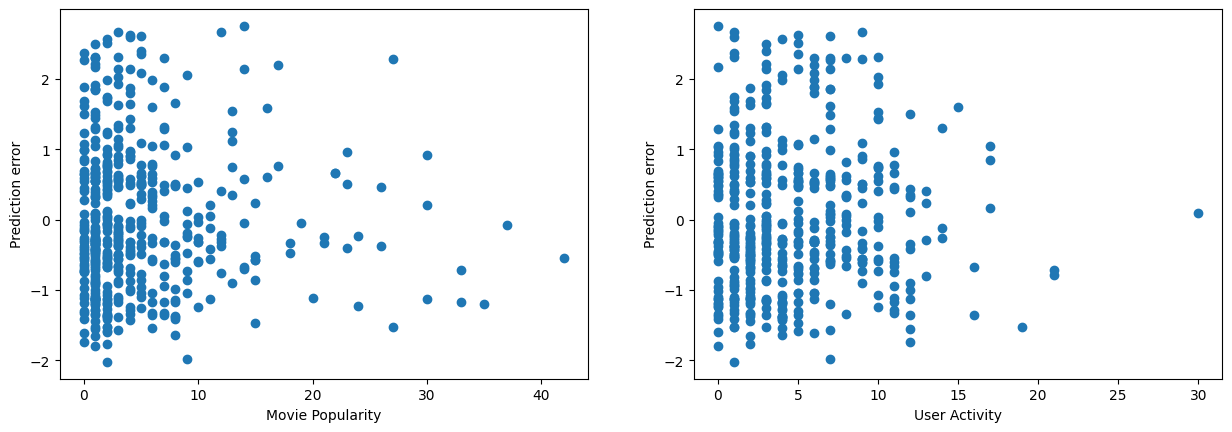

In [69]:
# only plot a subsample for higher readability
subn = 500
fig, (ax0, ax1) = plt.subplots(ncols=2)
fig.set_figwidth(15)
ax0.scatter(movie_popularity[:subn], err[:subn])
ax0.set_ylabel('Prediction error')
ax0.set_xlabel('Movie Popularity')

ax1.scatter(user_activity[:subn], err[:subn])
ax1.set_ylabel('Prediction error')
ax1.set_xlabel('User Activity');

Above we plotted the prediction error of (a subset of) test ratings compared to the popularity of movies (left) and activity level of users (right). We note that:

- This empirical distribution looks symmetrical so there doesn't seem to be a bias toward lower or higher predictions
- The prediction errors seem to show that movies and users with more data have smaller prediction error (i.e., the data forms a "triangle" pointing to the right, this is much clearer when running w. more training data which we limit here to save time). This is intuitive, the more data you have about an item the more accurate should be the estimation of its parameters ($\theta_{\text{mid}}$). This could also be reinforced by the fact that we are splitting ratings randomly for train and test (versus splitting by user or item). Hence, popular movies and high-activity users have a great influence in the learning process.

### 2.3 Linear regression with tag features/covariates

We use a linear regression model as above but also model movie tags:

$$
f(x_{ui}) = \theta_\text{gender} x_{\text{gender}_u} + \theta_{\text{age}} x_{\text{age}_u} + \theta_\text{zip} x_{\text{zip}_u} + \theta_\text{occupation} x_{\text{occupation}_u} + \theta_\text{uid} x_{\text{uid}_u} + \theta_{\text{mid}} x_{\text{mid}_i} \mathbf{+ x_{\text{tags}_i}\boldsymbol\theta_\text{tags}}
$$

The last term on the right-hand side (bolded) is the only difference wrt to our previous model.  

**Question 5:** How do you think that this new model will compare to the previous model of Section 2.2? Can you say something definitive about its performance?

**Hint:** One model is a special case of another.

In [ ]:
# This is very similar to how we constructed our dataset above except that we add the tags columns
X_tags = data_pd_dum.filter(regex=('('+attributes+"|tid_*"+')'))
print(X_tags.shape)

# Split Train/Test. Notice that we use the same seed as above to replicate that split.
X_train_tags, X_test_tags, y_train_tags, y_test_tags = train_test_split(
    X_tags, rating, test_size=0.4, random_state=1234, shuffle=False)
print(X_train_tags.shape)

In [ ]:
# Create linear regression object
regr_tags = linear_model.Ridge(alpha=10)

# Train the model using the training sets
start = time.time()
regr_tags.fit(X_train_tags, y_train_tags)
fit_time = time.time() - start

print("fitting time: %.2f seconds" % fit_time)
print("number of parameters:", regr_tags.coef_.shape[0]+1)

In [ ]:
# Make train predictions
y_train_pred = regr_tags.predict(X_train_tags)

print("Train Mean squared error: %.4f"
      % mean_squared_error(y_train_tags, y_train_pred))

# Make test predictions
y_test_pred = regr_tags.predict(X_test_tags)

print("Test Mean squared error: %.4f"
      % mean_squared_error(y_test_tags, y_test_pred))

Remarks: We obtain a test MSE of 1.13 for model 2.3 compared to a test MSE of 1.28 for model 2.2. So the tags do seem to provide slightly better test performance at the expense of a slightly larger model (968 extra parameters to fit) which takes about 30% longer to fit. Take this with a grain of salt because it is hardware dependent. But, this hints at the fact that the fitting algorithm is not linear (i.e., increasing the number of parameters by 10% yields an increase of 30% in running time).

***

### 2.4 Fitting a non-linear model

So far we have studied the effect of using different features on a linear model. We note that adding features seems to help, as long as the features provide novel and predictive information and are not redundant.

Here we explore a non-linear model, a one-hidden layer neural network for regression. The task and the data are the same as before, only the model changes.

**Neural network basics:** (We will discuss these models in some depth over the next two weeks.)
- A neural network is made up of interconnected *neurons*. Each neuron computes a few simple operations.
- In a *feed-forward network*, neurons are organized into sets called *layers*.
 - Neurons in each layer get their inputs from the previous layer and send their outputs to the next layer.
 - The first layer is called the *input layer* it provides data to the next layer. The last layer is the *output layer* it provides a prediction $\hat{y}$.
 - Layers in between the input layer and the output layer are called *hidden layers*. Each neuron in the hidden layers is a linear regression model followed by a non-linear function (*activation function*): $f(x) = \sum_i x_i \theta_i$.
  - The number of neurons in the input and output layers are fixed by the data (the number of features and the number of predictions).
  - The number of neurons of a hidden layer is a hyperparameter. Another hyperparameter is the number of hidden layers.

Mathematically for a regression task (with a single output), a one-hidden layer neural net is:
$$
f(x) = f_\text{o} ( \sum_{j=0}^{|\text{hidden n.}|} \theta'_{j} f_\text{h}( \sum_{i=0}^{|p|}\theta_{ij} x_i ) )
$$
where
- $\theta_{ij}$ are the parameters of input $i$ and neuron $j$ in the hidden layer.
- $f_h$ is the activation function of the hidden layer
- $\theta'_{j}$ are the parameters that connect the neuron $j$ in the hidden layer to the output layer.
- $f_o$ is the activation function of the output layer

An intuitive way of visualization a neural net (especially large ones) is to draw neurons as nodes and connections between neurons as arcs:

In [ ]:
# a 1 hidden layer neural net, where the input has 10 dimensions (p=10) and the output 1
input_dims = 10 # p
hidden_layers_size = [4] # number of hidden neurons for each hidden layer (adding a dimension adds a layer)
output_dims = 1 # number of outputs

network = DrawNN( [input_dims] + hidden_layers_size + [output_dims] )
network.draw()

In [ ]:
# Fit a neural network on this data.
regr_nn = neural_network.MLPRegressor(alpha=0.1, # l2-regularization (weight decay)
                                      hidden_layer_sizes=tuple(hidden_layers_size),
                                      early_stopping=True, # stop if validation performance decreases
                                      verbose=True,
                                      random_state=1234)
start = time.time()
regr_nn.fit(X_train_tags.values, y_train_tags)
fit_time = time.time() - start

print("fitting time: %.2f seconds" % fit_time)
print("number of parameters:", reduce(lambda x,y: x+y,
                                       list(map(lambda x: x.size, regr_nn.coefs_+regr_nn.intercepts_)) ))

Much like previous models we can regularize a neural net to combat overfitting:
- Here we use the same L2-penalty regularizer on all parameters. The strength of this regularizer is given by $\alpha$.
- In addition, we use a second regularizer called `early-stopping`. Learning the parameters of a neural network is done iteratively using a method called gradient descent (as opposed to linear regression, there is no analytical solution for the parameters given the objective function). Early stopping simply evaluates the validation error after each iteration. It stops learning when the validation error stops improving. This can happen before the training loss converges. When it does not, then this regularizer has no effect on learning. In `scikit-learn`, the MLPRegressor class with `early_stopping=True` automatically splits a validation set from the training set to be used by this regularizer. The disadvantage, of course, is that this reduces the amount of data used to fit parameters.

**Question 6:** Why does this model come with the possibility to set the random seed (i.e., `random_state`) while linear regression did not?

In [ ]:
# Make train predictions
y_train_pred = regr_nn.predict(X_train_tags.values)

print("Train Mean squared error: %.4f"
      % mean_squared_error(y_train_tags, y_train_pred))

# Make test predictions
y_test_pred = regr_nn.predict(X_test_tags.values)

print("Test Mean squared error: %.4f"
      % mean_squared_error(y_test_tags, y_test_pred))
#Train Mean squared error: 0.6623
#Test Mean squared error: 1.0465

Here is our updated table of results

| Model        | Test MSE           |
| ------------- |:-------------:|
| 2.2 (Linear Reg. w. basic features)     | 1.28 | 0.865  |
| 2.3 (2.2 + movie tags)     | 1.15 | 0.857 |
| 2.4 (Neural Network w. features from 2.3) | 1.18 | 0.865 |

Although neural networks are very powerful models, on this task the performance of our neural net does not outperform a simpler linear regression model. This of course does not mean that a different neural net (for example, one with more neurons per layer or more layers or just one trained from different hyperparameters) could not do better.

<a id="concluding-remarks"></a>
### Section 3. Concluding Remarks

The goal of this tutorial was to put in practice some of the principles that we have discussed since the start of this course (and hint at some of the things that are coming in the next weeks). We will spend one full week (week #11) thinking about preference data including where it's coming from and how to model it.

Here are a few more parting thoughts:

#### Machine Learning

As you might have noticed, applied machine learning is a very empirical endeavour. Once you have data in the right format, it is typical to fit it using several models, each time trying to understand the advantages/disadvantages of each model and getting a more thorough understanding of the data. In practice, this last part may be crucial and we did not adress it much in this tutorial (instead focussing on the models themeselves).


#### Scikit-learn
`scikit-learn` is a powerful ML library. It is meant as a model (and data pre-processing) toolbox. It provides an interface to a wide variety of models, it is actively developped, and in general seen as a very good plateform. It is also open source and free to use.

Model Selection, i.e., which model should I use for a particular dataset/task can be daunting. [This page](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) provides some tips particular to `scikit-learn`. In general, when working on a new task/dataset it is often useful to try and compare different models. Remember that in practice (mean) test-performance is only one of the possible desiderata (others include running time both for training and other metrics like false positive rates).

Note that `scikit-learn` does not fit every use case. For example, its support of modern neural networks is fairly modest. It is also not meant as a development plateform for new models.

#### Other packages

Software is one of the reasons behind the rise of modern machine learning. Modern software automatize a number of tasks which allow programmers and researchers alike to be much more efficient. `scikit-learn` is one popular package for fitting machine learning models but there exist others (both applied and also for exploration/development purposes). All in all, it can be useful to know about these packages but (in my opinion) it is more useful to have a good understanding of the fundamentals of the field as the package landscape changes rapidly and one can always learn one more.


#### Food for thought
 - In our models we assumed that ratings were the dependent variable (y) and that we had covariates (e.g., features of users and movies). Imagine a setting where we don't have any features or, somewhat equivalently, only have features that end up not being predictive of ratings. In that case the linear regression model would be:

$$
f(x_{ui}) = \theta_\text{uid} x_{\text{uid}_u} + \theta_{\text{mid}} x_{\text{mid}_i}
$$


- **Question 7:** What's wrong with the above model? Try to think about it for a minute or two before looking at the answer.



- As we will see during week 11 (on recommender systems), many models take ratings as output **and** as input. For example, one could take a user's previous ratings and try to predict one's future ratings (for example using an auto-encoder model). This is a nice way to build models that do not require any user/item covariates (and these models can also be extended when that data exist).

## References


Scikit-learn
- [Documentation](https://scikit-learn.org/stable/documentation.html)
- [Tutorials](https://scikit-learn.org/stable/tutorial/index.html)
- [Help for model selection](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)